In [1]:
import copy
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
from collections import deque

l0 = 4
l1 = 32
l2 = 64
l3 = 128
l4 = 1
dimen = 7
middle_ = (int((dimen - 3)/2) + 1) - 2
middle = middle_ * middle_ * l3

while l4 <= middle:
  l4 *= 2

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

model = torch.nn.Sequential(
    torch.nn.Conv2d(l0, l1, kernel_size=2, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(l1, l2, kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(l2, l3, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(middle, l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4, l0)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0

for i in range(epochs*int(dimen/2)):
    game = Gridworld(size=dimen, mode='random')
    state1_ = (game.board.render_np() + np.random.rand(*(game.board.render_np().shape))/100.0)
    state1 = torch.from_numpy(state1_).float().reshape((1,4,dimen,dimen))
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = (game.board.render_np() + np.random.rand(*(game.board.render_np().shape))/100.0)
        state2 = torch.from_numpy(state2_).float().reshape(1,4,dimen,dimen)
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

14999 0.019093655049800873


In [2]:
def test_model(dimension,model, mode='static', display=True):
  i = 0
  test_game = Gridworld(size=dimension,mode=mode)
  state_ = (test_game.board.render_np() + np.random.rand(*game.board.render_np().shape)/100.0)
  state = torch.from_numpy(state_).float().reshape((1,4,dimension,dimension))
  if display:
    print("Initial State:")
    print(test_game.display())
  status = 1
  while(status == 1):
    qval = model(state)
    qval_ = qval.data.numpy()
    action_ = np.argmax(qval_)
    action = action_set[action_]
    if display:
      print('Move #: %s; Taking action: %s' % (i, action))
    test_game.makeMove(action)
    state_ = (test_game.board.render_np() + np.random.rand(*game.board.render_np().shape)/100.0)
    state = torch.from_numpy(state_).float().reshape((1,4,dimension,dimension))
    if display:
      print(test_game.display())
    reward = test_game.reward()
    if reward != -1:
      if reward > 0:
        status = 2
        if display:
          print("Game won! Reward: %s" % (reward, ))
      else:
        status = 0
        if display:
          print("Game lost! Reward: %s" % (reward, ))
    i += 1
    if (i > 15):
      if display:
        print("Game lost; too many moves.")
      break
  win = True if status == 2 else False
  return win

Games played: 1000, # of wins: 758
Win percentage: 75.8%


Text(0, 0.5, 'Loss')

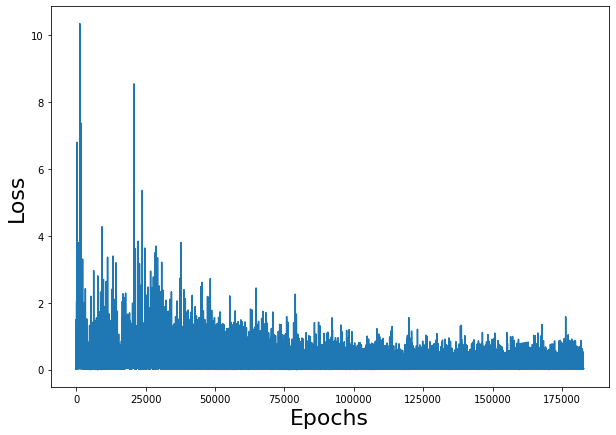

In [3]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(dimen, model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)